# Exploration Notebook

This notebook is a mess, basically my scratch notebook where I was figuring stuff out. Not going to do too much annotation here, but includes tuning, plotting and scratch code.

In [1]:
import pandas as pd
from darts.models import Prophet
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from darts.models import GaussianProcessFilter
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import BlockRNNModel
import numpy as np
from darts.utils.likelihood_models import LaplaceLikelihood

kernel = RBF()

targets = pd.read_csv("aquatics-targets.csv.gz")
barc_site = targets[targets.site_id == "BARC"]

gpf_missing = GaussianProcessFilter(kernel=kernel, alpha=0.001, n_restarts_optimizer=100)
gpf_missing_big_gaps = GaussianProcessFilter(kernel=kernel, alpha=0.2, n_restarts_optimizer=100)

In [2]:
barc_o = barc_site[barc_site.variable == "oxygen"]
times = pd.to_datetime(barc_o["datetime"])
times = pd.DatetimeIndex(times)
oxy_tseries = TimeSeries.from_times_and_values(times, barc_o["observation"], fill_missing_dates=True, freq="D")

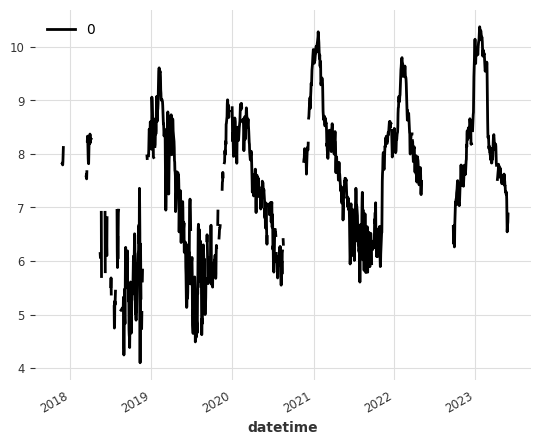

In [3]:
import matplotlib.pyplot as plt
plt.clf()
oxy_tseries.plot()
plt.show()

In [4]:
filtered_oxygen = gpf_missing.filter(oxy_tseries, num_samples=500)

In [5]:
filtered_oxygen_big_gaps = gpf_missing_big_gaps.filter(oxy_tseries, num_samples=500)

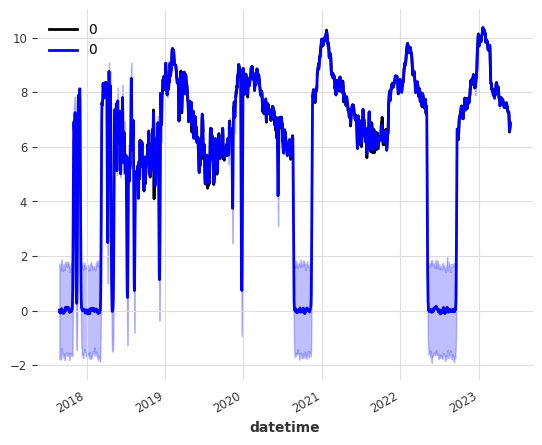

In [6]:
plt.clf()
oxy_tseries.plot()
filtered_oxygen.plot(color="blue")
plt.show()

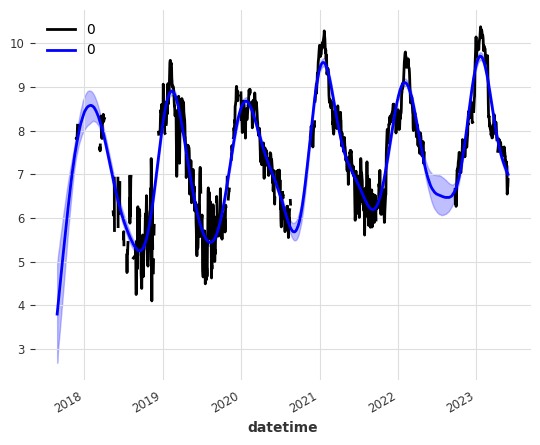

In [7]:
plt.clf()
oxy_tseries.plot()
filtered_oxygen_big_gaps.plot(color="blue")
plt.show()

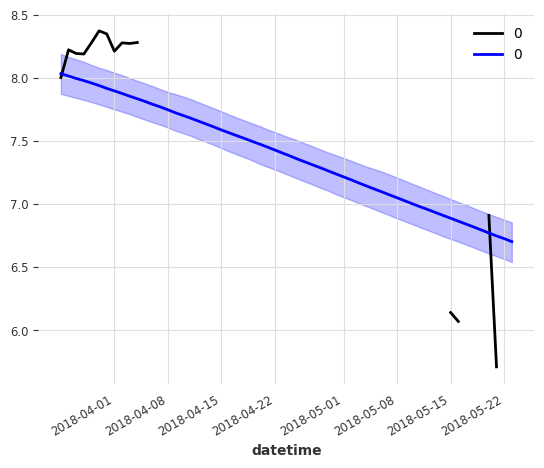

In [8]:
x=210
plt.clf()
oxy_tseries[x:x+60].plot()
filtered_oxygen_big_gaps[x:x+60].plot(color="blue")
plt.show()

In [9]:
#if there is a gap over 7 indices, use big gap filter
gap_series = oxy_tseries.gaps()
stitched_df = filtered_oxygen.pd_dataframe()
replacement_df = filtered_oxygen_big_gaps.pd_dataframe()

for index, row in gap_series.iterrows():
    if row["gap_size"] > 7:
        for date in pd.date_range(row["gap_start"], row["gap_end"]):
            stitched_df.loc[date] = replacement_df.loc[date]

stitched = TimeSeries.from_times_and_values(stitched_df.index, stitched_df.values.reshape(len(stitched_df), 1, -1))

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


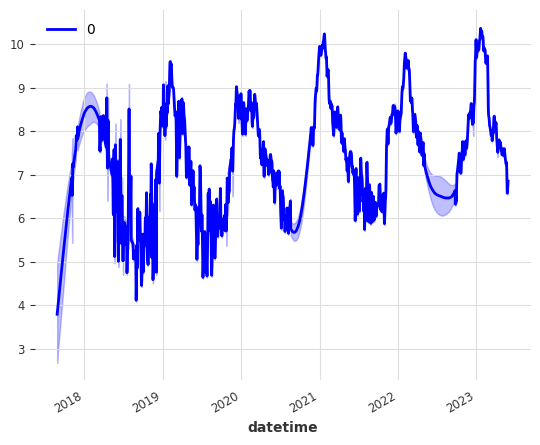

In [10]:
#drop_date = pd.Timestamp(year=2018, month=1, day=1)
plt.clf()
stitched.plot(color="blue")
#stitched.drop_before(drop_date).plot(color="blue")
plt.show()

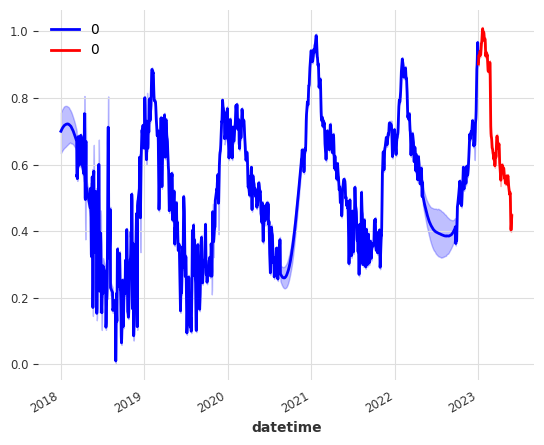

In [11]:
from darts.dataprocessing.transformers import Scaler

drop_date = pd.Timestamp(year=2018, month=1, day=1)
val_split = pd.Timestamp(year=2023, month=1, day=1)

train_oxy = stitched.drop_before(drop_date)
train_oxy, val_oxy = train_oxy.split_after(val_split)
scaler = Scaler()

train_oxy_scaled = scaler.fit_transform(train_oxy)
val_oxy_scaled = scaler.transform(val_oxy)

plt.clf()
train_oxy_scaled.plot(color="blue")
val_oxy_scaled.plot(color="red")
plt.show()

In [41]:
from darts.models import RNNModel
from darts.utils.likelihood_models import LaplaceLikelihood
from functools import reduce
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"
drop_date = pd.Timestamp(year=2018, month=1, day=1)

val_split = pd.Timestamp(year=2023, month=1, day=1)

rnn_oxy = RNNModel(model="LSTM",
                    hidden_dim=64,
                    dropout=0,
                    batch_size=8,
                    input_chunk_length=30,
                    output_chunk_length=34,
                    likelihood=LaplaceLikelihood(),
                    n_rnn_layers=5,
                    random_state=0)

rnn_oxy.fit(train_oxy_scaled,
            val_series=val_oxy_scaled,
            epochs=250, 
            verbose=False)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.


RNNModel(model=LSTM, hidden_dim=64, n_rnn_layers=5, dropout=0, training_length=24, batch_size=8, input_chunk_length=30, output_chunk_length=34, likelihood=<darts.utils.likelihood_models.LaplaceLikelihood object at 0x7fb10c28c430>, random_state=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


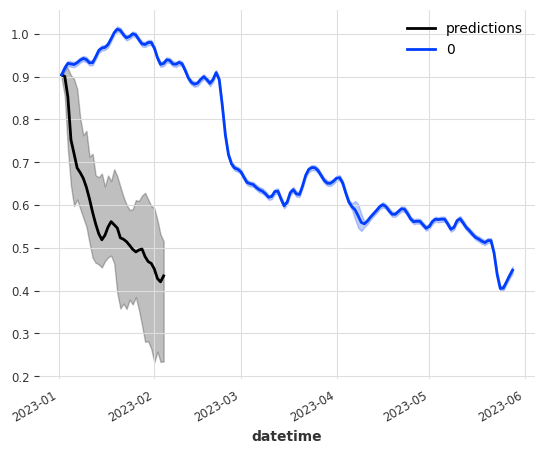

In [44]:
predictions = rnn_oxy.predict(n=34, num_samples=50)

plt.clf()
predictions.plot(label="predictions")
val_oxy_scaled.plot()
plt.show()

In [45]:
from darts.models import RNNModel
from darts.utils.likelihood_models import LaplaceLikelihood
from functools import reduce
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"
drop_date = pd.Timestamp(year=2018, month=1, day=1)

val_split = pd.Timestamp(year=2023, month=1, day=1)

rnn_oxy = RNNModel(model="LSTM",
                    hidden_dim=64,
                    dropout=0,
                    batch_size=8,
                    input_chunk_length=30,
                    output_chunk_length=34,
                    likelihood=LaplaceLikelihood(),
                    n_rnn_layers=5,
                    random_state=1)

rnn_oxy.fit(train_oxy_scaled,
            val_series=val_oxy_scaled,
            epochs=250, 
            verbose=False)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.


RNNModel(model=LSTM, hidden_dim=64, n_rnn_layers=5, dropout=0, training_length=24, batch_size=8, input_chunk_length=30, output_chunk_length=34, likelihood=<darts.utils.likelihood_models.LaplaceLikelihood object at 0x7fb10c15f550>, random_state=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


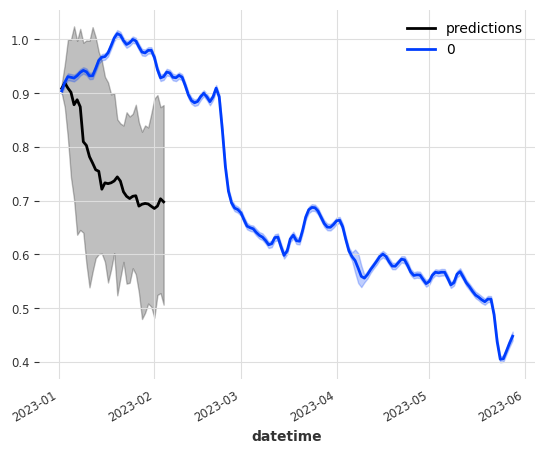

In [47]:
predictions = rnn_oxy.predict(n=34, num_samples=50)

plt.clf()
predictions.plot(label="predictions")
val_oxy_scaled.plot()
plt.show()

In [50]:
models = []
num_models = 5

for i in range(num_models):
    rnn_oxy = RNNModel(model="LSTM",
                        hidden_dim=64,
                        dropout=0,
                        batch_size=8,
                        input_chunk_length=30,
                        output_chunk_length=34,
                        likelihood=LaplaceLikelihood(),
                        optimizer_kwargs={"lr": 1e-3},
                        n_rnn_layers=5,
                        random_state=i)
    
    rnn_oxy.fit(train_oxy_scaled,
                val_series=val_oxy_scaled,
                epochs=250, 
                verbose=False)

    models.append(rnn_oxy)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reac

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


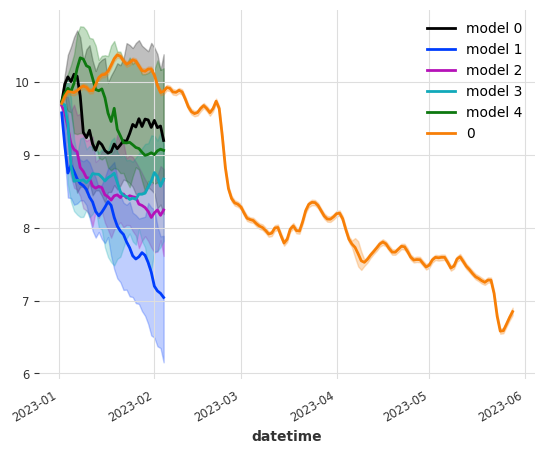

In [52]:
plt.clf()
for index, model in enumerate(models):
    predictions = model.predict(n=34, num_samples=50)
    scaler.inverse_transform(predictions).plot(label=f"model {index}")
scaler.inverse_transform(val_oxy_scaled).plot()
plt.show()

# Tuning

In [19]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import Callback, EarlyStop`aping
from sklearn.preprocessing import MaxAbsScaler

from darts.datasets import ElectricityDataset
from darts.models import TCNModel, LinearRegressionModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape

from darts.models import RNNModel
from darts.utils.likelihood_models import LaplaceLikelihood
from functools import reduce
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [118]:
def objective(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # Hyperparameters
    hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128])
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    input_chunk_length = trial.suggest_categorical("input_chunk_length", [7, 15, 30, 60])
    n_rnn_layers = trial.suggest_categorical("n_rnn_layers", [2, 3, 5])
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)

    rnn_oxy = BlockRNNModel(model="LSTM",
                            hidden_dim=hidden_dim,
                            batch_size=batch_size,
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=34,
                            likelihood=LaplaceLikelihood(),
                            optimizer_kwargs={"lr": lr},
                            n_rnn_layers=n_rnn_layers)

    rnn_oxy.fit(train_set,
                past_covariates=train_covariates,
                epochs=250, 
                verbose=False)

    predictions = rnn_oxy.predict(n=len(val_set), past_covariates=past_covariates, num_samples=50)
    smapes = smape(val_set, predictions, n_jobs=-1, verbose=False)
    smape_val = np.mean(smapes)

    return smape_val if smape_val != np.nan else float("inf")


In [ ]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=100, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
# study.optimize(objective, n_trials=100, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2023-06-06 20:48:34,715] A new study created in memory with name: no-name-28289011-d21a-4384-9904-d7eef7a602ba
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 20:50:04,346] Trial 0 finished with value: 7.1231289449343675 and parameters: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 7, 'n_rnn_layers': 3, 'lr': 0.0006654224642537396}. Best is trial 0 with value: 7.1231289449343675.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 7.1231289449343675, Current params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 7, 'n_rnn_layers': 3, 'lr': 0.0006654224642537396}
Best value: 7.1231289449343675, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 7, 'n_rnn_layers': 3, 'lr': 0.0006654224642537396}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 20:59:06,137] Trial 1 finished with value: 7.375375151292694 and parameters: {'hidden_dim': 64, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.0001078413087458767}. Best is trial 0 with value: 7.1231289449343675.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 7.375375151292694, Current params: {'hidden_dim': 64, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.0001078413087458767}
Best value: 7.1231289449343675, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 7, 'n_rnn_layers': 3, 'lr': 0.0006654224642537396}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 21:02:30,733] Trial 2 finished with value: 18.190965698615763 and parameters: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 30, 'n_rnn_layers': 3, 'lr': 0.0006105828834812916}. Best is trial 0 with value: 7.1231289449343675.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 18.190965698615763, Current params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 30, 'n_rnn_layers': 3, 'lr': 0.0006105828834812916}
Best value: 7.1231289449343675, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 7, 'n_rnn_layers': 3, 'lr': 0.0006654224642537396}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 21:06:18,960] Trial 3 finished with value: 5.177729651045875 and parameters: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 5.177729651045875, Current params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 21:15:24,476] Trial 4 finished with value: 8.112421479964484 and parameters: {'hidden_dim': 64, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.000295303666235812}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 8.112421479964484, Current params: {'hidden_dim': 64, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.000295303666235812}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 21:18:02,884] Trial 5 finished with value: 7.049943127798413 and parameters: {'hidden_dim': 64, 'batch_size': 16, 'input_chunk_length': 15, 'n_rnn_layers': 2, 'lr': 0.00019194278471241707}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 7.049943127798413, Current params: {'hidden_dim': 64, 'batch_size': 16, 'input_chunk_length': 15, 'n_rnn_layers': 2, 'lr': 0.00019194278471241707}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 21:21:15,743] Trial 6 finished with value: 7.420337123079909 and parameters: {'hidden_dim': 64, 'batch_size': 16, 'input_chunk_length': 7, 'n_rnn_layers': 5, 'lr': 0.0004922047046839144}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 7.420337123079909, Current params: {'hidden_dim': 64, 'batch_size': 16, 'input_chunk_length': 7, 'n_rnn_layers': 5, 'lr': 0.0004922047046839144}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 21:24:30,696] Trial 7 finished with value: 63.63292774180893 and parameters: {'hidden_dim': 32, 'batch_size': 16, 'input_chunk_length': 60, 'n_rnn_layers': 2, 'lr': 0.0009437209370508912}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 63.63292774180893, Current params: {'hidden_dim': 32, 'batch_size': 16, 'input_chunk_length': 60, 'n_rnn_layers': 2, 'lr': 0.0009437209370508912}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 21:29:51,873] Trial 8 finished with value: 6.3277868791545036 and parameters: {'hidden_dim': 64, 'batch_size': 16, 'input_chunk_length': 30, 'n_rnn_layers': 5, 'lr': 0.0007637489522940779}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 6.3277868791545036, Current params: {'hidden_dim': 64, 'batch_size': 16, 'input_chunk_length': 30, 'n_rnn_layers': 5, 'lr': 0.0007637489522940779}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 21:32:24,595] Trial 9 finished with value: 75.99249266738074 and parameters: {'hidden_dim': 64, 'batch_size': 32, 'input_chunk_length': 30, 'n_rnn_layers': 2, 'lr': 0.0007722423942773492}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 75.99249266738074, Current params: {'hidden_dim': 64, 'batch_size': 32, 'input_chunk_length': 30, 'n_rnn_layers': 2, 'lr': 0.0007722423942773492}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 21:38:57,651] Trial 10 finished with value: 19.242091102212516 and parameters: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 60, 'n_rnn_layers': 3, 'lr': 6.239718063096062e-05}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 19.242091102212516, Current params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 60, 'n_rnn_layers': 3, 'lr': 6.239718063096062e-05}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 21:44:08,951] Trial 11 finished with value: 6.2241486624088385 and parameters: {'hidden_dim': 128, 'batch_size': 16, 'input_chunk_length': 30, 'n_rnn_layers': 3, 'lr': 0.0003421213275308769}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 6.2241486624088385, Current params: {'hidden_dim': 128, 'batch_size': 16, 'input_chunk_length': 30, 'n_rnn_layers': 3, 'lr': 0.0003421213275308769}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 21:51:28,239] Trial 12 finished with value: 5.663572937071741 and parameters: {'hidden_dim': 128, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0003543836594893576}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 5.663572937071741, Current params: {'hidden_dim': 128, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0003543836594893576}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 21:58:45,326] Trial 13 finished with value: 6.235399231088391 and parameters: {'hidden_dim': 128, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0003903190741521137}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 6.235399231088391, Current params: {'hidden_dim': 128, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0003903190741521137}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:06:05,826] Trial 14 finished with value: 5.955841262867451 and parameters: {'hidden_dim': 128, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00020373828718717245}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 5.955841262867451, Current params: {'hidden_dim': 128, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00020373828718717245}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:09:55,084] Trial 15 finished with value: 7.022694307681676 and parameters: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0004846522468274439}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 7.022694307681676, Current params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0004846522468274439}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:13:45,844] Trial 16 finished with value: 6.847436294905017 and parameters: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00024857509349106126}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 6.847436294905017, Current params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00024857509349106126}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:21:03,332] Trial 17 finished with value: 7.053239677433434 and parameters: {'hidden_dim': 128, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043285342844915525}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 7.053239677433434, Current params: {'hidden_dim': 128, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043285342844915525}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:25:45,086] Trial 18 finished with value: 6.769643581721127 and parameters: {'hidden_dim': 128, 'batch_size': 8, 'input_chunk_length': 7, 'n_rnn_layers': 3, 'lr': 0.00030108045147795535}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 6.769643581721127, Current params: {'hidden_dim': 128, 'batch_size': 8, 'input_chunk_length': 7, 'n_rnn_layers': 3, 'lr': 0.00030108045147795535}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:31:18,855] Trial 19 finished with value: 18.023048880689736 and parameters: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 60, 'n_rnn_layers': 2, 'lr': 0.00015202098706426902}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 18.023048880689736, Current params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 60, 'n_rnn_layers': 2, 'lr': 0.00015202098706426902}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:33:38,227] Trial 20 finished with value: 5.208578944292662 and parameters: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0005462385977696101}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 5.208578944292662, Current params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0005462385977696101}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:35:58,492] Trial 21 finished with value: 9.226332607145457 and parameters: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0005283533474763271}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 9.226332607145457, Current params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0005283533474763271}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:38:22,951] Trial 22 finished with value: 6.48539650944826 and parameters: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.000345835017964145}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 6.48539650944826, Current params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.000345835017964145}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:40:42,670] Trial 23 finished with value: 5.41382133352515 and parameters: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043612634005900315}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 5.41382133352515, Current params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043612634005900315}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:43:01,916] Trial 24 finished with value: 6.569595252703933 and parameters: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0006010730225516697}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 6.569595252703933, Current params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0006010730225516697}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:44:52,243] Trial 25 finished with value: 8.749040389127448 and parameters: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00045446053360619304}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 8.749040389127448, Current params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00045446053360619304}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:47:11,380] Trial 26 finished with value: 5.727943519140295 and parameters: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0009338091951107546}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 5.727943519140295, Current params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0009338091951107546}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:50:55,841] Trial 27 finished with value: 30.286748880257658 and parameters: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 3, 'lr': 0.0005681832106831736}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 30.286748880257658, Current params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 3, 'lr': 0.0005681832106831736}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:53:01,262] Trial 28 finished with value: 8.533147767642705 and parameters: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 7, 'n_rnn_layers': 5, 'lr': 0.0004193988738706373}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 8.533147767642705, Current params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 7, 'n_rnn_layers': 5, 'lr': 0.0004193988738706373}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:54:26,665] Trial 29 finished with value: 7.53038064707197 and parameters: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 7, 'n_rnn_layers': 2, 'lr': 0.0006885463301905862}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 7.53038064707197, Current params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 7, 'n_rnn_layers': 2, 'lr': 0.0006885463301905862}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 22:56:50,392] Trial 30 finished with value: 6.1990462991342135 and parameters: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0005384318382920044}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 6.1990462991342135, Current params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0005384318382920044}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 23:04:09,473] Trial 31 finished with value: 7.572465197843186 and parameters: {'hidden_dim': 128, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0003820445396272742}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 7.572465197843186, Current params: {'hidden_dim': 128, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0003820445396272742}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 23:11:29,651] Trial 32 finished with value: 6.342492105321972 and parameters: {'hidden_dim': 128, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0002818780683413438}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 6.342492105321972, Current params: {'hidden_dim': 128, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0002818780683413438}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 23:13:50,675] Trial 33 finished with value: 5.457840778316857 and parameters: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0003837483433688472}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 5.457840778316857, Current params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0003837483433688472}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 23:16:10,650] Trial 34 finished with value: 6.814544542868635 and parameters: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0006373896139960036}. Best is trial 3 with value: 5.177729651045875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 6.814544542868635, Current params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.0006373896139960036}
Best value: 5.177729651045875, Best params: {'hidden_dim': 32, 'batch_size': 8, 'input_chunk_length': 15, 'n_rnn_layers': 3, 'lr': 0.00043691212551126313}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 23:19:14,624] Trial 35 finished with value: 4.879913104103654 and parameters: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.0004542008428214828}. Best is trial 35 with value: 4.879913104103654.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 4.879913104103654, Current params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.0004542008428214828}
Best value: 4.879913104103654, Best params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.0004542008428214828}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 23:21:22,708] Trial 36 finished with value: 5.46430529380497 and parameters: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.00047204085623270834}. Best is trial 35 with value: 4.879913104103654.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 5.46430529380497, Current params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.00047204085623270834}
Best value: 4.879913104103654, Best params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.0004542008428214828}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 23:25:10,188] Trial 37 finished with value: 7.877743970339803 and parameters: {'hidden_dim': 64, 'batch_size': 32, 'input_chunk_length': 30, 'n_rnn_layers': 5, 'lr': 0.0006912710714642829}. Best is trial 35 with value: 4.879913104103654.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 7.877743970339803, Current params: {'hidden_dim': 64, 'batch_size': 32, 'input_chunk_length': 30, 'n_rnn_layers': 5, 'lr': 0.0006912710714642829}
Best value: 4.879913104103654, Best params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.0004542008428214828}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 23:28:08,817] Trial 38 finished with value: 12.064973147550367 and parameters: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.0005196768238943977}. Best is trial 35 with value: 4.879913104103654.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 12.064973147550367, Current params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.0005196768238943977}
Best value: 4.879913104103654, Best params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.0004542008428214828}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 23:31:23,290] Trial 39 finished with value: 10.167256242631877 and parameters: {'hidden_dim': 64, 'batch_size': 16, 'input_chunk_length': 7, 'n_rnn_layers': 5, 'lr': 0.0003106214378428236}. Best is trial 35 with value: 4.879913104103654.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 10.167256242631877, Current params: {'hidden_dim': 64, 'batch_size': 16, 'input_chunk_length': 7, 'n_rnn_layers': 5, 'lr': 0.0003106214378428236}
Best value: 4.879913104103654, Best params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.0004542008428214828}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 23:36:52,886] Trial 40 finished with value: 5.222534783165429 and parameters: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00025453906144556394}. Best is trial 35 with value: 4.879913104103654.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 5.222534783165429, Current params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00025453906144556394}
Best value: 4.879913104103654, Best params: {'hidden_dim': 128, 'batch_size': 32, 'input_chunk_length': 15, 'n_rnn_layers': 5, 'lr': 0.0004542008428214828}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 23:42:22,469] Trial 41 finished with value: 4.58816853830622 and parameters: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}. Best is trial 41 with value: 4.58816853830622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 4.58816853830622, Current params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}
Best value: 4.58816853830622, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 23:47:52,421] Trial 42 finished with value: 7.866643613799258 and parameters: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.0002303790182842568}. Best is trial 41 with value: 4.58816853830622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 7.866643613799258, Current params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.0002303790182842568}
Best value: 4.58816853830622, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 23:53:22,461] Trial 43 finished with value: 13.372892189128024 and parameters: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00025612003424588194}. Best is trial 41 with value: 4.58816853830622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 13.372892189128024, Current params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00025612003424588194}
Best value: 4.58816853830622, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-06 23:58:40,100] Trial 44 finished with value: 7.994354738630603 and parameters: {'hidden_dim': 32, 'batch_size': 16, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00032754454810113726}. Best is trial 41 with value: 4.58816853830622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 7.994354738630603, Current params: {'hidden_dim': 32, 'batch_size': 16, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00032754454810113726}
Best value: 4.58816853830622, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-07 00:04:10,168] Trial 45 finished with value: 14.180843585931985 and parameters: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.000195169164051747}. Best is trial 41 with value: 4.58816853830622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 14.180843585931985, Current params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.000195169164051747}
Best value: 4.58816853830622, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-07 00:09:38,901] Trial 46 finished with value: 11.607146387440606 and parameters: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00016110610454041593}. Best is trial 41 with value: 4.58816853830622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 11.607146387440606, Current params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00016110610454041593}
Best value: 4.58816853830622, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-07 00:15:08,932] Trial 47 finished with value: 17.96428112947136 and parameters: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.0003555763873568807}. Best is trial 41 with value: 4.58816853830622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 17.96428112947136, Current params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.0003555763873568807}
Best value: 4.58816853830622, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-07 00:18:34,618] Trial 48 finished with value: 6.319378069821342 and parameters: {'hidden_dim': 32, 'batch_size': 16, 'input_chunk_length': 30, 'n_rnn_layers': 5, 'lr': 0.00025822579883873843}. Best is trial 41 with value: 4.58816853830622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 6.319378069821342, Current params: {'hidden_dim': 32, 'batch_size': 16, 'input_chunk_length': 30, 'n_rnn_layers': 5, 'lr': 0.00025822579883873843}
Best value: 4.58816853830622, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-07 00:22:36,438] Trial 49 finished with value: 4.648478471406435 and parameters: {'hidden_dim': 64, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 2, 'lr': 0.0002888762436466066}. Best is trial 41 with value: 4.58816853830622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 4.648478471406435, Current params: {'hidden_dim': 64, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 2, 'lr': 0.0002888762436466066}
Best value: 4.58816853830622, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-07 00:26:34,049] Trial 50 finished with value: 60.18866900284651 and parameters: {'hidden_dim': 64, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 2, 'lr': 0.00029426752512097445}. Best is trial 41 with value: 4.58816853830622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 60.18866900284651, Current params: {'hidden_dim': 64, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 2, 'lr': 0.00029426752512097445}
Best value: 4.58816853830622, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-07 00:30:36,253] Trial 51 finished with value: 8.332038325244268 and parameters: {'hidden_dim': 64, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 2, 'lr': 0.00021861730808524988}. Best is trial 41 with value: 4.58816853830622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 8.332038325244268, Current params: {'hidden_dim': 64, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 2, 'lr': 0.00021861730808524988}
Best value: 4.58816853830622, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-07 00:34:33,614] Trial 52 finished with value: 5.783358033590268 and parameters: {'hidden_dim': 64, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 2, 'lr': 0.000263682824711463}. Best is trial 41 with value: 4.58816853830622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 5.783358033590268, Current params: {'hidden_dim': 64, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 2, 'lr': 0.000263682824711463}
Best value: 4.58816853830622, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}


`Trainer.fit` stopped: `max_epochs=250` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-07 00:38:35,745] Trial 53 finished with value: 34.92522790068389 and parameters: {'hidden_dim': 64, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 2, 'lr': 0.00039128000886492716}. Best is trial 41 with value: 4.58816853830622.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 34.92522790068389, Current params: {'hidden_dim': 64, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 2, 'lr': 0.00039128000886492716}
Best value: 4.58816853830622, Best params: {'hidden_dim': 32, 'batch_size': 32, 'input_chunk_length': 60, 'n_rnn_layers': 5, 'lr': 0.00023839320387037522}


/home/rstudio/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

# Exploring Again

In [113]:
models = []
num_models = 5

for i in range(num_models):
    rnn_oxy = RNNModel(model="LSTM",
                        hidden_dim=32,
                        batch_size=8,
                        input_chunk_length=7,
                        output_chunk_length=34,
                        likelihood=LaplaceLikelihood(),
                        optimizer_kwargs={"lr": 1e-4},
                        n_rnn_layers=2,
                        random_state=i)
    
    rnn_oxy.fit(train_oxy_scaled,
                val_series=val_oxy_scaled,
                epochs=250, 
                verbose=False)

    models.append(rnn_oxy)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reac

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

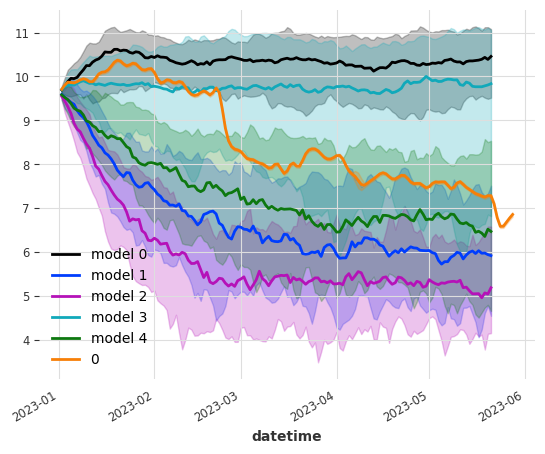

In [114]:
plt.clf()
for index, model in enumerate(models):
    predictions = model.predict(n=140, num_samples=50)
    scaler.inverse_transform(predictions).plot(label=f"model {index}")
scaler.inverse_transform(val_oxy_scaled).plot()
plt.show()

In [2]:
models = []
num_models = 5
val_split = pd.Timestamp(year=2023, month=1, day=1)
train_set, val_set = x["oxygen"].split_before(val_split)
train_covariates, val_covariates = past_covariates.split_before(val_split)

for i in range(num_models):
    rnn_oxy = BlockRNNModel(model="LSTM",
                            hidden_dim=32,
                            batch_size=32,
                            input_chunk_length=60,
                            output_chunk_length=34,
                            likelihood=LaplaceLikelihood(),
                            optimizer_kwargs={"lr": 2e-4},
                            n_rnn_layers=5,
                            random_state=i)
    
    rnn_oxy.fit(train_set,
            past_covariates=train_covariates,
            epochs=250, 
            verbose=False)

    models.append(rnn_oxy)

NameError: name 'pd' is not defined

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

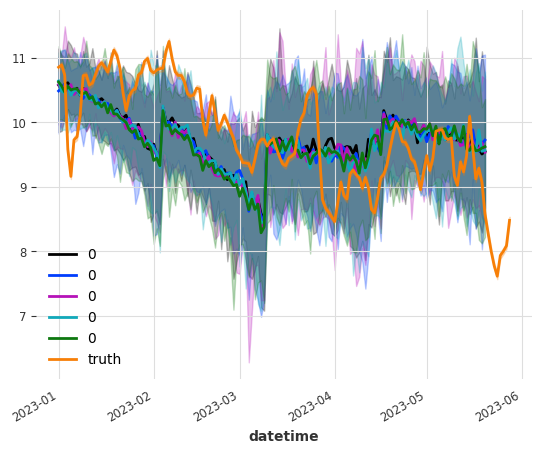

In [116]:
plt.clf()
for index, model in enumerate(models):
    predictions = rnn_oxy.predict(n=140, past_covariates=past_covariates, num_samples=50)
    predictions.plot()
val_set.plot(label="truth")
plt.show()

Ok so now looking at expanding this to other sites, variables:

In [62]:
def make_stitched_series(site, targets_df):
    """
    Returns a dictionary {"variable": stitched time series of variable}
    """
    variables = ["chla", "oxygen", "temperature"]
    site_df = targets[targets.site_id == site]
    stitched_series = {}
    
    for variable in variables:
        variable_df = site_df[site_df.variable == variable]
        times = pd.to_datetime(variable_df["datetime"])
        times = pd.DatetimeIndex(times)
        variable_tseries = TimeSeries.from_times_and_values(times, variable_df["observation"], fill_missing_dates=True, freq="D")

        # Filtering the TimeSeries
        try:
            filtered = gpf_missing.filter(variable_tseries, num_samples=500)
            filtered_big_gaps = gpf_missing_big_gaps.filter(variable_tseries, num_samples=500)
        except:
            continue
    
        #if there is a gap over 7 indices, use big gap filter
        gap_series = variable_tseries.gaps()
        stitched_df = filtered.pd_dataframe()
        replacement_df = filtered_big_gaps.pd_dataframe()
        
        for index, row in gap_series.iterrows():
            if row["gap_size"] > 7:
                for date in pd.date_range(row["gap_start"], row["gap_end"]):
                    stitched_df.loc[date] = replacement_df.loc[date]
        
        stitched_series[variable] = TimeSeries.from_times_and_values(stitched_df.index, stitched_df.values.reshape(len(stitched_df), 1, -1))

    return stitched_series

In [63]:
targets["site_id"].unique()

array(['ARIK', 'BARC', 'BIGC', 'BLDE', 'BLUE', 'BLWA', 'CARI', 'COMO',
       'CRAM', 'CUPE', 'FLNT', 'GUIL', 'HOPB', 'KING', 'LECO', 'LEWI',
       'LIRO', 'MART', 'MAYF', 'MCDI', 'MCRA', 'OKSR', 'POSE', 'PRIN',
       'PRLA', 'PRPO', 'REDB', 'SUGG', 'SYCA', 'TECR', 'TOMB', 'TOOK',
       'WALK', 'WLOU'], dtype=object)

In [50]:
ARIK_stitched = make_stitched_series("ARIK", targets)

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

In [64]:
def plot_stitched(site_id):
    stitched = make_stitched_series(site_id, targets)
    for var in stitched.keys():
        stitched[var].plot(label=var)

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

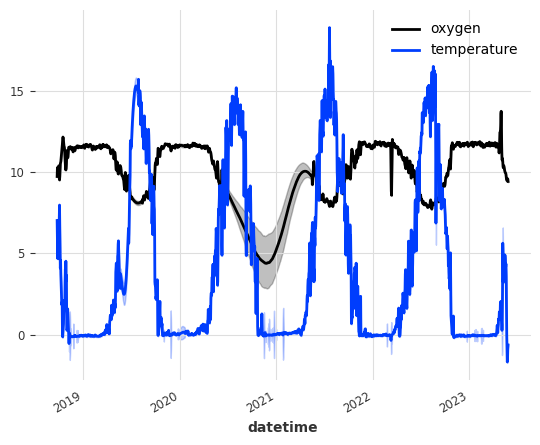

In [65]:
plot_stitched(targets["site_id"].unique()[3])

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

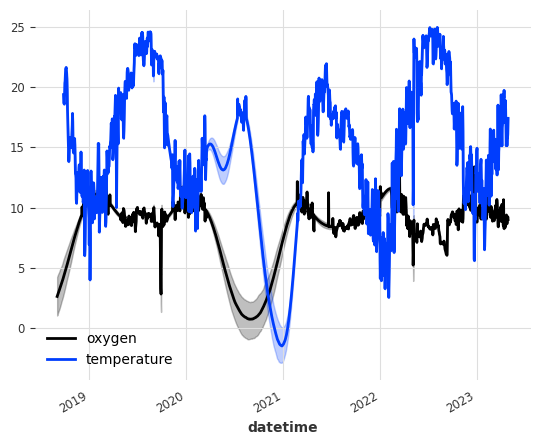

In [66]:
plot_stitched(targets["site_id"].unique()[4])

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

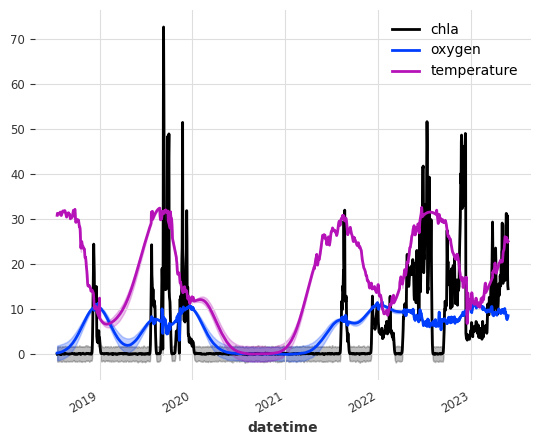

In [67]:
plot_stitched(targets["site_id"].unique()[5])

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

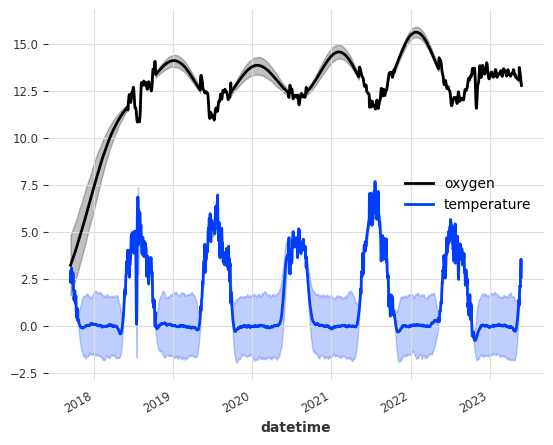

In [68]:
plot_stitched(targets["site_id"].unique()[6])

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

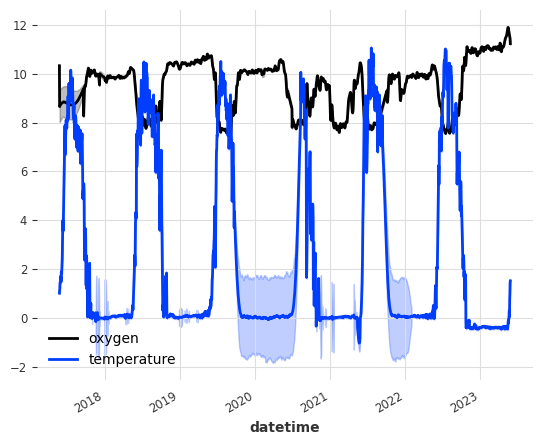

In [69]:
plot_stitched(targets["site_id"].unique()[7])

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

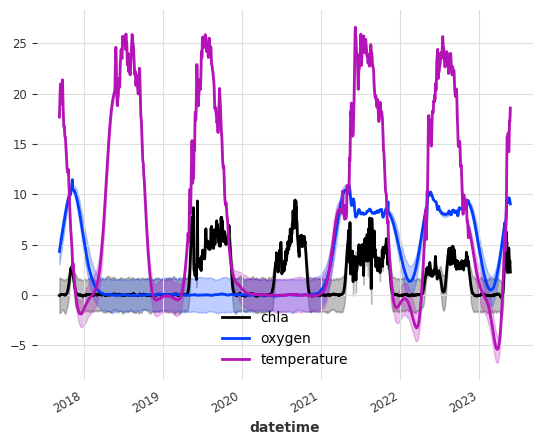

In [70]:
plot_stitched(targets["site_id"].unique()[8])

In [71]:
def train_models(site_id):
    """
    Returns a dictionary {site_id: [ml_model, scaled validation set, scaler]}
    """
    #Note site_stitched is a dictionary {"var": tseries}
    site_stitched = make_stitched_series(site_id, targets)

    models = {} 

    for var in site_stitched.keys():
        rnn = RNNModel(model="LSTM",
                            hidden_dim=32,
                            batch_size=8,
                            input_chunk_length=7,
                            output_chunk_length=34,
                            likelihood=LaplaceLikelihood(),
                            optimizer_kwargs={"lr": 1e-4},
                            n_rnn_layers=2,
                            random_state=0)
        
        # Set a date to split between train and validation set
        val_split = pd.Timestamp(year=2023, month=1, day=1)
        train_set, val_set = site_stitched[var].split_before(val_split)

        scaler = Scaler()
        train_scaled = scaler.fit_transform(train_set)
        val_scaled = scaler.transform(val_set)
        
        rnn.fit(train_scaled,
                    val_series=val_scaled,
                    epochs=250, 
                    verbose=False)
    
        models[var] = [rnn, val_scaled, scaler]

    return models

In [72]:
asst = train_models(targets["site_id"].unique()[5])

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

In [74]:
def plot_var(var, ast):
    plt.clf()
    predictions = ast[var][0].predict(n=34, num_samples=50)
    ast[var][2].inverse_transform(predictions).plot(label=f"predictions")
    ast[var][2].inverse_transform(ast[var][1]).plot()
    plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

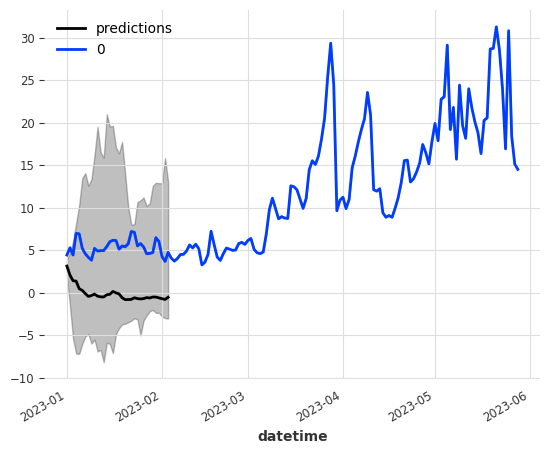

In [77]:
plot_var("chla", asst)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

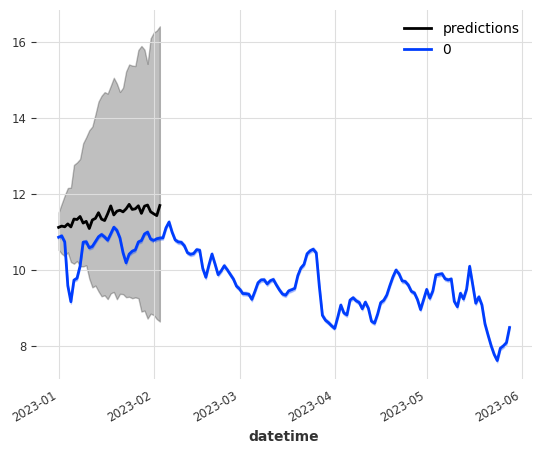

In [78]:
plot_var("oxygen", asst)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

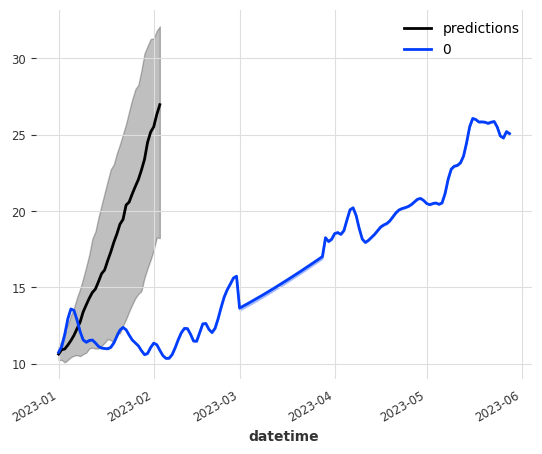

In [79]:
plot_var("temperature", asst)

Now I want to try to use covariates, this time just sticking to the ones given to me:

In [81]:
x = make_stitched_series(targets["site_id"].unique()[5], targets)

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

In [83]:
x.keys()

dict_keys(['chla', 'oxygen', 'temperature'])

In [84]:
covariates = x["chla"].stack(x["temperature"])

In [99]:
from darts.models import BlockRNNModel

val_split = pd.Timestamp(year=2023, month=1, day=1)
train_set, val_set = x["oxygen"].split_before(val_split)
train_covariates, val_covariates = past_covariates.split_before(val_split)

rnn_oxy = BlockRNNModel(model="LSTM",
                        hidden_dim=32,
                        batch_size=8,
                        input_chunk_length=7,
                        output_chunk_length=34,
                        likelihood=LaplaceLikelihood(),
                        optimizer_kwargs={"lr": 1e-4},
                        n_rnn_layers=2)
    
rnn_oxy.fit(train_set,
            past_covariates=train_covariates,
            epochs=250, 
            verbose=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=250` reached.


In [101]:
pred_cov = rnn_oxy.historical_forecasts(train_set, 
                                        past_covariates=train_covariates, 
                                        num_samples=50,
                                        forecast_horizon=34,
                                        stride=30,
                                        retrain=False,
                                        show_warnings=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), us

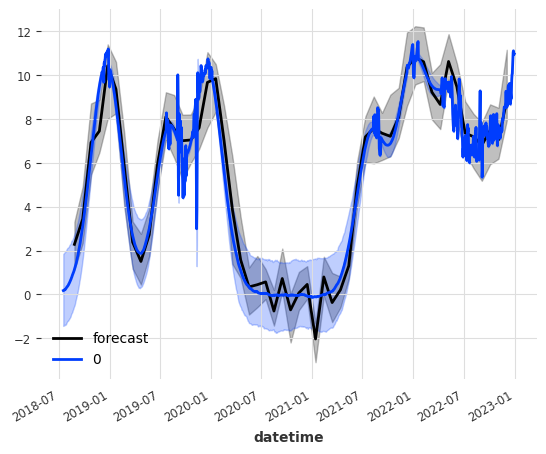

In [102]:
plt.clf()
pred_cov.plot(label="forecast")
train_set.plot()
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

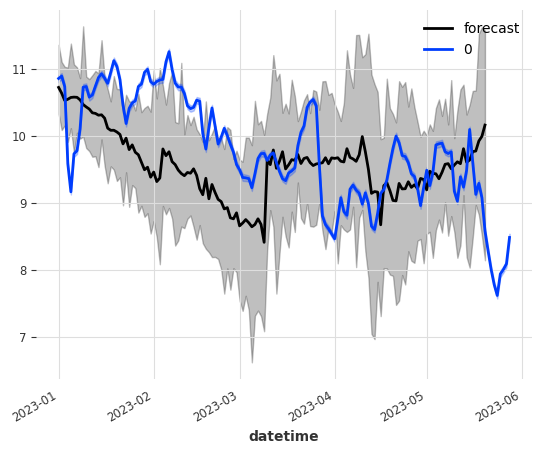

In [111]:
plt.clf()
predictions = rnn_oxy.predict(n=140, past_covariates=past_covariates, num_samples=50)
predictions.plot(label="forecast")
val_set.plot()
plt.show()

In [ ]:
site_stitched